# 03. Model 1: Learning Behavior Clustering

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

PROCESSED_DIR = '../data/processed'
MODELS_DIR = '../models'
os.makedirs(MODELS_DIR, exist_ok=True)

print("✅ Environment Ready!")

✅ Environment Ready!


---
# 1. LOAD DATA

In [10]:
df = pd.read_csv(os.path.join(PROCESSED_DIR, 'clustering_features.csv'))

feature_cols = [
    'avg_study_hour',           
    'study_consistency_std',    
    'completion_speed',         
    'avg_exam_score',          
    'submission_fail_rate',    
    'retry_count'              
]

X_raw = df[feature_cols].copy()
print(f"📂 Dataset Shape: {df.shape}\n")

# Check for missing values
print("Missing Values:")
print(X_raw.isnull().sum())
print("\n✓ Data Loaded Successfully")

📂 Dataset Shape: (2008, 23)

Missing Values:
avg_study_hour           0
study_consistency_std    0
completion_speed         0
avg_exam_score           0
submission_fail_rate     0
retry_count              0
dtype: int64

✓ Data Loaded Successfully


---
# 2. ADVANCED FEATURE SELECTION

### Strategy:
1. **Correlation Analysis**: Hapus features dengan korelasi > 0.8 (redundant)
2. **Variance Threshold**: Hapus features dengan variance sangat rendah
3. **Outlier Removal**: Gunakan IsolationForest untuk menghilangkan extreme outliers

ADVANCED FEATURE SELECTION

📊 1. Correlation Matrix:


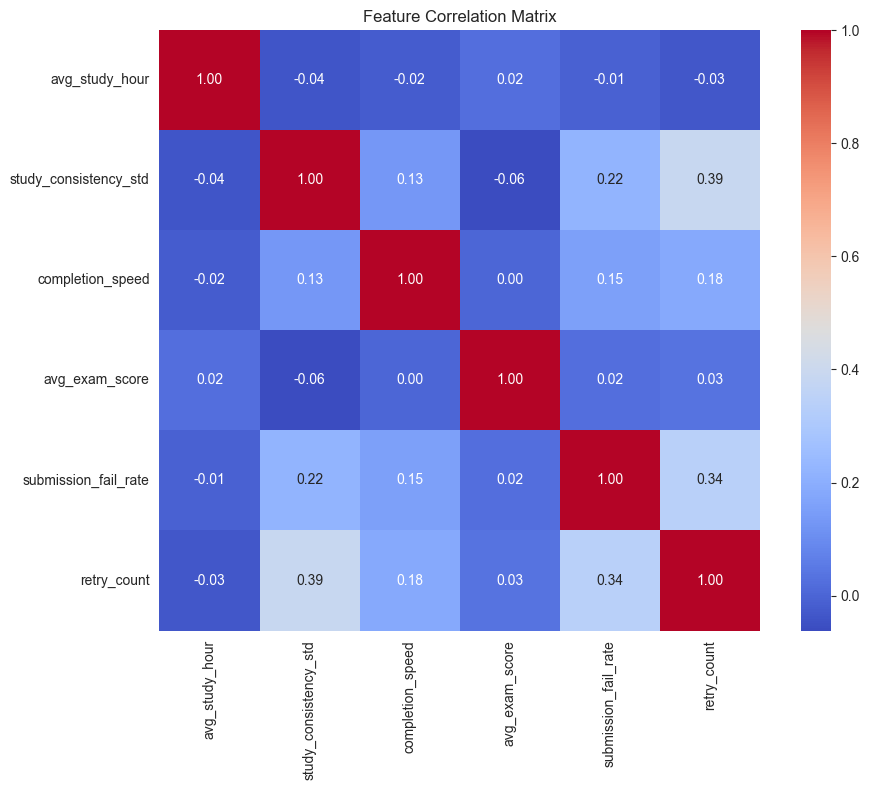

   ✓ No highly correlated features found

📊 2. Variance Analysis:
submission_fail_rate         0.198754
retry_count                  0.602784
completion_speed             3.736229
avg_study_hour              15.220874
avg_exam_score             166.056722
study_consistency_std    10430.623182
dtype: float64
   ✓ All features have sufficient variance

🧹 3. Outlier Removal (IsolationForest):
   ✓ Detected 101 outliers (5.03%)

✅ Final Feature Set: ['avg_study_hour', 'study_consistency_std', 'completion_speed', 'avg_exam_score', 'submission_fail_rate', 'retry_count']
   Original: 2008 samples
   After Cleaning: 1907 samples (95.0%)


In [11]:
print("="*60)
print("ADVANCED FEATURE SELECTION")
print("="*60)

# Step 1: Correlation Analysis
print("\n📊 1. Correlation Matrix:")
corr_matrix = X_raw.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Remove highly correlated features (correlation > 0.8)
threshold = 0.8
correlated_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

features_to_drop = set()
if correlated_pairs:
    print(f"\n⚠️ Found {len(correlated_pairs)} highly correlated pairs (>{threshold}):")
    for f1, f2, corr in correlated_pairs:
        print(f"   {f1} <-> {f2}: {corr:.2f}")
        # Drop the second feature in each pair
        features_to_drop.add(f2)
    X_selected = X_raw.drop(columns=list(features_to_drop))
    print(f"   ✓ Dropped features: {list(features_to_drop)}")
else:
    X_selected = X_raw.copy()
    print(f"   ✓ No highly correlated features found")

# Step 2: Variance Threshold
print("\n📊 2. Variance Analysis:")
variance = X_selected.var()
print(variance.sort_values())

# Keep features with variance > 0.01
low_variance = variance[variance < 0.01].index.tolist()
if low_variance:
    print(f"   ⚠️ Low variance features: {low_variance}")
    X_selected = X_selected.drop(columns=low_variance)
else:
    print("   ✓ All features have sufficient variance")

# Step 3: Outlier Removal (IsolationForest)
print("\n🧹 3. Outlier Removal (IsolationForest):")
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(X_selected)
outliers = (outlier_labels == -1).sum()
print(f"   ✓ Detected {outliers} outliers ({outliers/len(X_selected):.2%})")

# Create clean dataset
df_clean = df[outlier_labels == 1].reset_index(drop=True)
X_clean = X_selected[outlier_labels == 1].reset_index(drop=True)

print(f"\n✅ Final Feature Set: {list(X_clean.columns)}")
print(f"   Original: {X_raw.shape[0]} samples")
print(f"   After Cleaning: {X_clean.shape[0]} samples ({X_clean.shape[0]/X_raw.shape[0]:.1%})")

---
# 3. SCALER COMPARISON

We will compare 3 different scalers:
1. **PowerTransformer** (Yeo-Johnson)
2. **RobustScaler** (resistant to outliers)
3. **StandardScaler** (baseline)

In [12]:
print("="*60)
print("SCALER COMPARISON")
print("="*60)

scalers = {
    'PowerTransformer': PowerTransformer(method='yeo-johnson', standardize=True),
    'RobustScaler': RobustScaler(),
    'StandardScaler': StandardScaler()
}

scaled_datasets = {}
for name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_clean)
    scaled_datasets[name] = X_scaled
    print(f"\n✓ {name} applied")

# We will test each scaler during clustering
print("\n✅ All scalers ready for comparison")

SCALER COMPARISON

✓ PowerTransformer applied

✓ RobustScaler applied

✓ StandardScaler applied

✅ All scalers ready for comparison


---
# 4. OPTIMAL K SEARCH (Comprehensive)

We will test:
1. **Elbow Method** (Inertia)
2. **Silhouette Score**
3. **Calinski-Harabasz Index**

For each scaler, we find the optimal K.

OPTIMAL K SEARCH

Testing PowerTransformer
   K=2: Silhouette=0.2764, CH=643.83
   K=3: Silhouette=0.2966, CH=566.19
   K=4: Silhouette=0.2366, CH=521.09
   K=5: Silhouette=0.2620, CH=513.43
   K=6: Silhouette=0.2737, CH=482.68
   K=7: Silhouette=0.2668, CH=466.28

   ⭐ Best Statistical K=3 (Silhouette=0.2966)

Testing RobustScaler
   K=2: Silhouette=0.8977, CH=5864.80
   K=3: Silhouette=0.8548, CH=8161.92
   K=4: Silhouette=0.7838, CH=9259.51
   K=5: Silhouette=0.6762, CH=10293.46
   K=6: Silhouette=0.7042, CH=12723.45
   K=7: Silhouette=0.7129, CH=17928.08

   ⭐ Best Statistical K=2 (Silhouette=0.8977)

Testing StandardScaler
   K=2: Silhouette=0.3012, CH=546.92
   K=3: Silhouette=0.3151, CH=495.38
   K=4: Silhouette=0.3298, CH=481.74
   K=5: Silhouette=0.2684, CH=509.99
   K=6: Silhouette=0.2883, CH=548.35
   K=7: Silhouette=0.3009, CH=543.39

   ⭐ Best Statistical K=4 (Silhouette=0.3298)


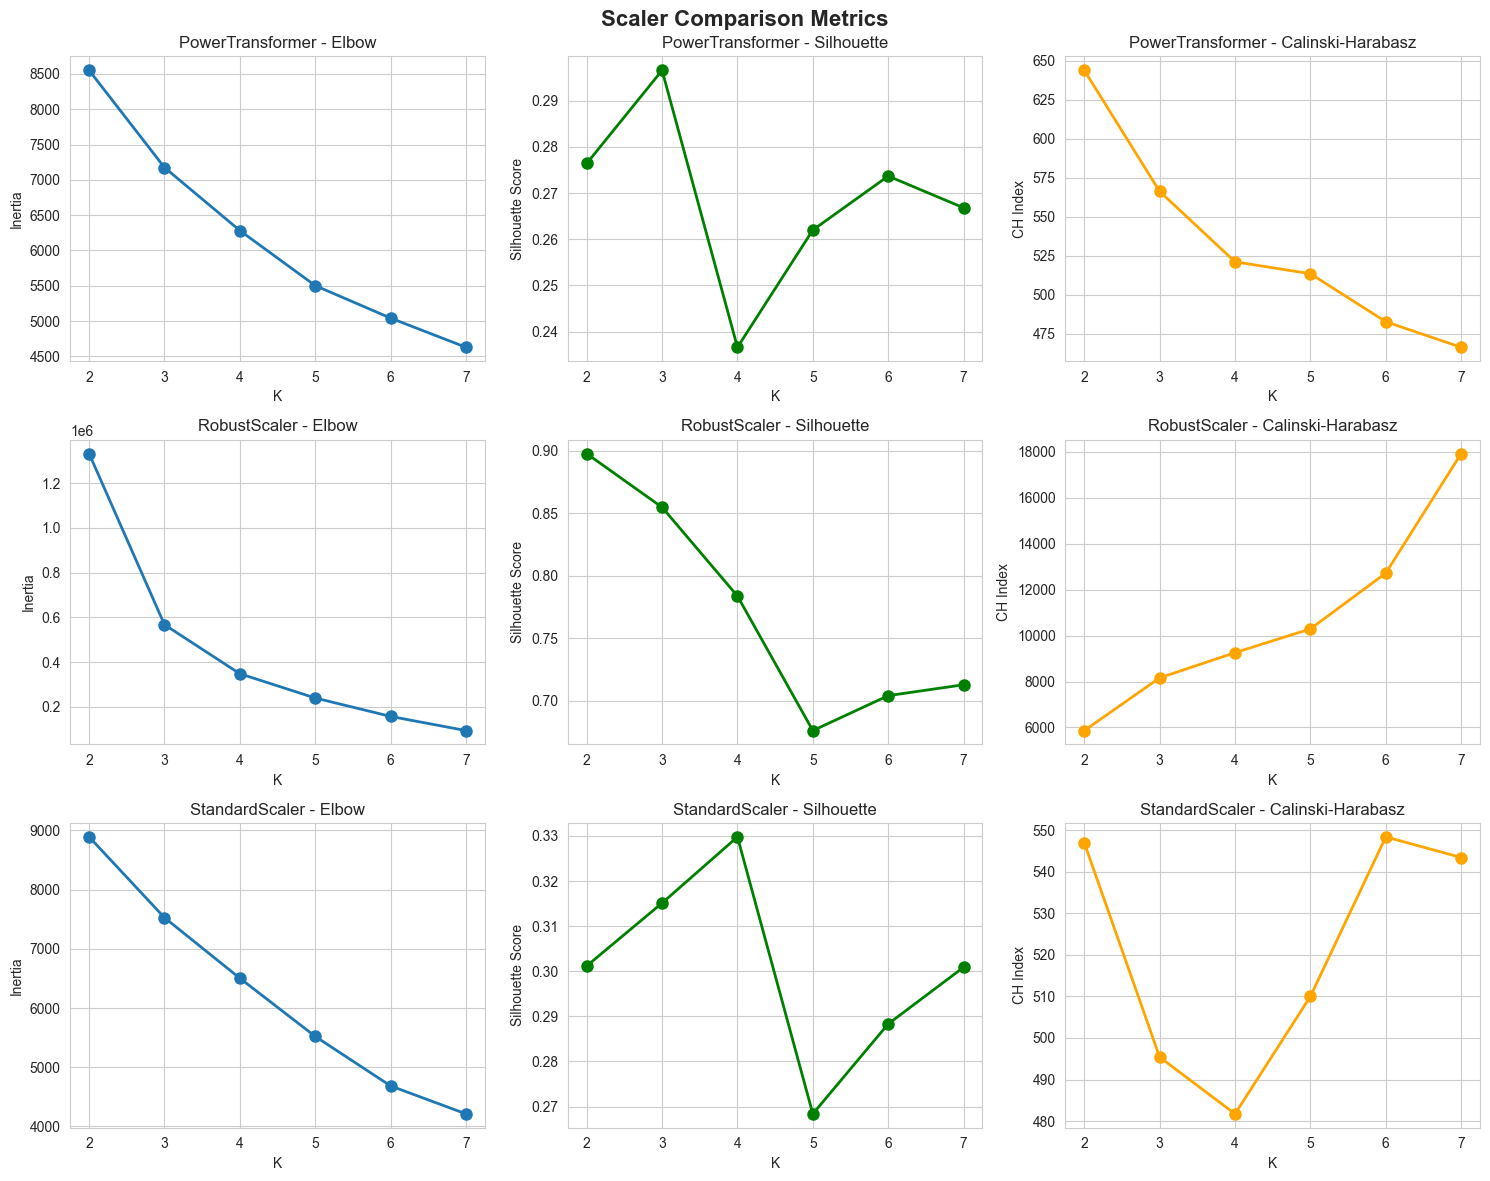


🏆 WINNER SCALER: RobustScaler


In [13]:
print("="*60)
print("OPTIMAL K SEARCH")
print("="*60)

K_range = range(2, 8)
results = {}

for scaler_name, X_scaled in scaled_datasets.items():
    print(f"\n{'='*60}")
    print(f"Testing {scaler_name}")
    print(f"{'='*60}")
    
    inertias = []
    silhouettes = []
    ch_scores = []
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=50, max_iter=500, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        
        inertia = kmeans.inertia_
        silhouette = silhouette_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)
        
        inertias.append(inertia)
        silhouettes.append(silhouette)
        ch_scores.append(ch)
        
        print(f"   K={k}: Silhouette={silhouette:.4f}, CH={ch:.2f}")
    
    results[scaler_name] = {
        'inertias': inertias,
        'silhouettes': silhouettes,
        'ch_scores': ch_scores
    }
    
    # Find best K based on silhouette (just for reference)
    best_k_stat = K_range[np.argmax(silhouettes)]
    best_silhouette_stat = max(silhouettes)
    print(f"\n   ⭐ Best Statistical K={best_k_stat} (Silhouette={best_silhouette_stat:.4f})")

# Visualize results
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Scaler Comparison Metrics', fontsize=16, weight='bold')

for idx, (scaler_name, metrics) in enumerate(results.items()):
    # Elbow
    axes[idx, 0].plot(K_range, metrics['inertias'], marker='o', linewidth=2, markersize=8)
    axes[idx, 0].set_title(f'{scaler_name} - Elbow')
    axes[idx, 0].set_xlabel('K')
    axes[idx, 0].set_ylabel('Inertia')
    axes[idx, 0].grid(True)
    
    # Silhouette
    axes[idx, 1].plot(K_range, metrics['silhouettes'], marker='o', linewidth=2, markersize=8, color='green')
    axes[idx, 1].set_title(f'{scaler_name} - Silhouette')
    axes[idx, 1].set_xlabel('K')
    axes[idx, 1].set_ylabel('Silhouette Score')
    axes[idx, 1].grid(True)
    
    # Calinski-Harabasz
    axes[idx, 2].plot(K_range, metrics['ch_scores'], marker='o', linewidth=2, markersize=8, color='orange')
    axes[idx, 2].set_title(f'{scaler_name} - Calinski-Harabasz')
    axes[idx, 2].set_xlabel('K')
    axes[idx, 2].set_ylabel('CH Index')
    axes[idx, 2].grid(True)

plt.tight_layout()
plt.show()

# Select the best scaler based on maximum silhouette overall
best_scaler_name = max(results.items(), key=lambda x: max(x[1]['silhouettes']))[0]
print(f"\n{'='*60}")
print(f"🏆 WINNER SCALER: {best_scaler_name}")
print(f"{'='*60}")

---
# 5. FINAL MODEL TRAINING (K=5)

We enforce **K=5** to match the business requirements:
1. The Sprinter
2. The Deep Diver
3. The Night Owl
4. The Struggler
5. The Consistent

In [14]:
print("="*60)
print("FINAL MODEL TRAINING (K=5)")
print("="*60)

# Enforce K=5
best_k = 5

# Recreate the best scaler
if best_scaler_name == 'PowerTransformer':
    final_scaler = PowerTransformer(method='yeo-johnson', standardize=True)
elif best_scaler_name == 'RobustScaler':
    final_scaler = RobustScaler()
else:
    final_scaler = StandardScaler()

X_final_scaled = final_scaler.fit_transform(X_clean)

# Train final KMeans with K=5
final_kmeans = KMeans(
    n_clusters=best_k,
    init='k-means++',
    n_init=100,
    max_iter=1000,
    random_state=42
)

df_clean['cluster'] = final_kmeans.fit_predict(X_final_scaled)

# Compute metrics
final_silhouette = silhouette_score(X_final_scaled, df_clean['cluster'])
final_ch = calinski_harabasz_score(X_final_scaled, df_clean['cluster'])

print(f"\n✅ Final Model Trained!")
print(f"   Scaler: {best_scaler_name}")
print(f"   K: {best_k} (Enforced for Business Req)")
print(f"   Silhouette Score: {final_silhouette:.4f}")
print(f"   Calinski-Harabasz: {final_ch:.2f}")

# Print cluster distribution
print(f"\n📊 Cluster Distribution:")
print(df_clean['cluster'].value_counts().sort_index())

FINAL MODEL TRAINING (K=5)

✅ Final Model Trained!
   Scaler: RobustScaler
   K: 5 (Enforced for Business Req)
   Silhouette Score: 0.6762
   Calinski-Harabasz: 10293.46

📊 Cluster Distribution:
cluster
0     400
1      49
2      35
3    1300
4     123
Name: count, dtype: int64


---
# 6. PERSONA ASSIGNMENT

Map 5 clusters to the 5 specific personas.

Kriteria:
1. The Night Owl: avg_study_hour >= 19 (aktif jam 19:00-24:00)
2. The Sprinter (Fast Learner): completion_speed RENDAH + avg_exam_score TINGGI
3. The Deep Diver (Slow Learner): completion_speed TINGGI + avg_exam_score TINGGI
4. The Struggler: avg_exam_score RENDAH + submission_fail_rate TINGGI
5. The Consistent: study_consistency_std RENDAH (belajar rutin & stabil)

In [15]:
print("="*60)
print("PERSONA ASSIGNMENT")
print("="*60)

# Get cluster centers (in original feature space)
centers_scaled = final_kmeans.cluster_centers_
centers_original = final_scaler.inverse_transform(centers_scaled)

# Create DataFrame for centers
center_df = pd.DataFrame(centers_original, columns=X_clean.columns)
center_df['cluster'] = range(best_k)

print("\\n📊 Cluster Centers (Original Scale):")
print(center_df.round(2))

# Define personas based on cluster characteristics
# We need to assign each cluster to exactly one persona
persona_mapping = {}

# Calculate global statistics for threshold reference
global_medians = center_df.median()
global_means = center_df.mean()

print("\\n📊 Global Statistics (Cluster Centers):")
print(f"   avg_study_hour - Mean: {global_means['avg_study_hour']:.2f}, Median: {global_medians['avg_study_hour']:.2f}")
print(f"   study_consistency_std - Mean: {global_means['study_consistency_std']:.2f}, Median: {global_medians['study_consistency_std']:.2f}")
print(f"   completion_speed - Mean: {global_means['completion_speed']:.2f}, Median: {global_medians['completion_speed']:.2f}")
print(f"   avg_exam_score - Mean: {global_means['avg_exam_score']:.2f}, Median: {global_medians['avg_exam_score']:.2f}")
print(f"   submission_fail_rate - Mean: {global_means['submission_fail_rate']:.2f}, Median: {global_medians['submission_fail_rate']:.2f}")

# Helper to find best matching cluster for a persona criteria
def find_best_cluster(criteria_func, exclude_clusters):
    best_cluster = -1
    best_score = -float('inf')
    
    for c_id in range(best_k):
        if c_id in exclude_clusters:
            continue
        center = center_df[center_df['cluster'] == c_id].iloc[0]
        score = criteria_func(center)
        if score > best_score:
            best_score = score
            best_cluster = c_id
    return best_cluster, best_score

print("\\n🔍 Assigning Personas Based on Design Criteria...")

# 1. The Night Owl: Highest avg_study_hour (or > 19)
def criteria_night_owl(center):
    # Prioritas tinggi jika avg_study_hour >= 19 (jam malam)
    if center['avg_study_hour'] >= 19:
        return center['avg_study_hour'] + 100  # Bonus besar
    # Jika tidak ada yang >= 19, ambil yang tertinggi
    return center['avg_study_hour']

c_night_owl, score_night_owl = find_best_cluster(criteria_night_owl, persona_mapping.keys())
owl_center = center_df[center_df['cluster'] == c_night_owl].iloc[0]
is_valid_owl = owl_center['avg_study_hour'] >= 19
persona_mapping[c_night_owl] = "The Night Owl"
print(f"   ✓ The Night Owl -> Cluster {c_night_owl} (avg_study_hour={owl_center['avg_study_hour']:.2f}, valid={is_valid_owl})")

# 2. The Sprinter: High speed (low completion_speed value) AND High score
# Note: completion_speed is days, so lower is faster.
def criteria_sprinter(center):
    # Kita ingin: speed RENDAH (cepat) + exam_score TINGGI
    # Gunakan exam_score - speed (speed rendah = nilai tinggi)
    speed_bonus = (global_means['completion_speed'] - center['completion_speed']) * 10  # Bonus jika lebih cepat
    exam_bonus = center['avg_exam_score']
    return speed_bonus + exam_bonus

c_sprinter, score_sprinter = find_best_cluster(criteria_sprinter, persona_mapping.keys())
sprinter_center = center_df[center_df['cluster'] == c_sprinter].iloc[0]
is_valid_sprinter = (sprinter_center['completion_speed'] < global_medians['completion_speed']) and \
                    (sprinter_center['avg_exam_score'] >= global_medians['avg_exam_score'])
persona_mapping[c_sprinter] = "The Sprinter"
print(f"   ✓ The Sprinter -> Cluster {c_sprinter} (completion_speed={sprinter_center['completion_speed']:.2f}, avg_exam_score={sprinter_center['avg_exam_score']:.2f}, valid={is_valid_sprinter})")

# 3. The Struggler: Low score AND High fail rate
def criteria_struggler(center):
    # Kombinasi: fail_rate tinggi, exam_score rendah, retry_count tinggi
    # Normalisasi dengan bobot
    fail_score = center['submission_fail_rate'] * 50  # fail_rate 0-1 -> 0-50
    low_exam_score = (100 - center['avg_exam_score']) / 2  # 0-50 (semakin rendah semakin tinggi skor)
    retry_penalty = center['retry_count'] * 5  # retry tinggi = bonus
    return fail_score + low_exam_score + retry_penalty

c_struggler, score_struggler = find_best_cluster(criteria_struggler, persona_mapping.keys())
struggler_center = center_df[center_df['cluster'] == c_struggler].iloc[0]
is_valid_struggler = (struggler_center['avg_exam_score'] < global_medians['avg_exam_score']) or \
                     (struggler_center['submission_fail_rate'] > global_medians['submission_fail_rate'])
persona_mapping[c_struggler] = "The Struggler"
print(f"   ✓ The Struggler -> Cluster {c_struggler} (avg_exam_score={struggler_center['avg_exam_score']:.2f}, fail_rate={struggler_center['submission_fail_rate']:.2f}, valid={is_valid_struggler})")

# 4. The Deep Diver: Slow speed (high completion_speed) AND Good score
def criteria_deep_diver(center):
    # Kita ingin: speed TINGGI (lambat) + exam_score TINGGI
    speed_bonus = center['completion_speed'] * 5  # Bonus jika lebih lambat
    exam_bonus = center['avg_exam_score']
    return speed_bonus + exam_bonus

c_deep_diver, score_deep_diver = find_best_cluster(criteria_deep_diver, persona_mapping.keys())
deep_diver_center = center_df[center_df['cluster'] == c_deep_diver].iloc[0]
# Deep Diver harus lambat (speed tinggi) DAN nilai bagus
is_valid_deep_diver = (deep_diver_center['completion_speed'] > global_medians['completion_speed']) or \
                      (deep_diver_center['avg_exam_score'] >= global_medians['avg_exam_score'])
persona_mapping[c_deep_diver] = "The Deep Diver"
print(f"   ✓ The Deep Diver -> Cluster {c_deep_diver} (completion_speed={deep_diver_center['completion_speed']:.2f}, avg_exam_score={deep_diver_center['avg_exam_score']:.2f}, valid={is_valid_deep_diver})")

# 5. The Consistent: Low consistency_std (more consistent) 
# Whatever is left is likely The Consistent, but let's verify
def criteria_consistent(center):
    # Kita ingin std RENDAH, jadi gunakan negatif (semakin rendah = skor lebih tinggi)
    return -center['study_consistency_std']

c_consistent, score_consistent = find_best_cluster(criteria_consistent, persona_mapping.keys())
consistent_center = center_df[center_df['cluster'] == c_consistent].iloc[0]
is_valid_consistent = consistent_center['study_consistency_std'] < global_medians['study_consistency_std']
persona_mapping[c_consistent] = "The Consistent"
print(f"   ✓ The Consistent -> Cluster {c_consistent} (study_consistency_std={consistent_center['study_consistency_std']:.2f}, below_median={is_valid_consistent})")

remaining_clusters = set(range(best_k)) - set(persona_mapping.keys())
if remaining_clusters:
    print(f"   ⚠️ Warning: Unassigned clusters: {remaining_clusters}")
    for c in remaining_clusters:
        # Assign as 'Unknown' or re-evaluate
        persona_mapping[c] = "The Consistent"  # Default fallback

# Apply persona mapping to dataframe
df_clean['persona'] = df_clean['cluster'].map(persona_mapping)

print("\\n" + "="*60)
print("📋 FINAL PERSONA MAPPING:")
print("="*60)
for cluster, persona in sorted(persona_mapping.items()):
    count = (df_clean['persona'] == persona).sum()
    center = center_df[center_df['cluster'] == cluster].iloc[0]
    print(f"\\n   Cluster {cluster} → {persona}")
    print(f"      Students: {count} ({count/len(df_clean):.1%})")
    print(f"      Key Features:")
    print(f"         - avg_study_hour: {center['avg_study_hour']:.2f}")
    print(f"         - study_consistency_std: {center['study_consistency_std']:.2f}")
    print(f"         - completion_speed: {center['completion_speed']:.2f}")
    print(f"         - avg_exam_score: {center['avg_exam_score']:.2f}")
    print(f"         - submission_fail_rate: {center['submission_fail_rate']:.2f}")
    print(f"         - retry_count: {center['retry_count']:.2f}")

print("\n✅ Persona Assignment Complete!")

PERSONA ASSIGNMENT
\n📊 Cluster Centers (Original Scale):
   avg_study_hour  study_consistency_std  completion_speed  avg_exam_score  \
0           13.70                  89.68              0.10           83.94   
1           12.84                  82.99              4.85           83.75   
2           13.35                  64.29              9.12           85.00   
3           13.95                  41.11              0.61           81.16   
4           14.00                  66.99              2.17           84.73   

   submission_fail_rate  retry_count  cluster  
0                  0.33         1.15        0  
1                  0.39         1.04        1  
2                  0.43         1.00        2  
3                  0.21         0.30        3  
4                  0.53         1.15        4  
\n📊 Global Statistics (Cluster Centers):
   avg_study_hour - Mean: 13.57, Median: 13.70
   study_consistency_std - Mean: 69.01, Median: 66.99
   completion_speed - Mean: 3.37, Median: 2.

---
# 7. SAVE FINAL MODEL

In [16]:
print("="*60)
print("SAVING FINAL MODEL")
print("="*60)

# Create a production-ready model dictionary
production_model = {
    'scaler': final_scaler,
    'clustering_model': final_kmeans,
    'persona_mapping': persona_mapping,
    'feature_columns': list(X_clean.columns),
    'outlier_detector': iso_forest,
    'model_metadata': {
        'scaler_type': best_scaler_name,
        'n_clusters': best_k,
        'silhouette_score': final_silhouette,
        'calinski_harabasz': final_ch,
        'features_dropped': list(features_to_drop) if features_to_drop else [],
        'outliers_removed': outliers
    }
}

# Save single model file
model_path = os.path.join(MODELS_DIR, 'clustering_model_production.pkl')
joblib.dump(production_model, model_path)

print(f"\n✅ Production model saved to: {model_path}")
print(f"   Model includes:")
print(f"      • Scaler: {best_scaler_name}")
print(f"      • KMeans (K={best_k})")
print(f"      • Persona Mapping")
print(f"      • Feature List")
print(f"      • Outlier Detector")
print(f"      • Model Metadata")
print(f"\n📊 Model Performance:")
print(f"      • Silhouette Score: {final_silhouette:.4f}")
print(f"      • Calinski-Harabasz: {final_ch:.2f}")

# Save labeled data
output_path = os.path.join(PROCESSED_DIR, 'clustering_results.csv')
df_clean[['developer_id', 'cluster', 'persona'] + list(X_clean.columns)].to_csv(output_path, index=False)
print(f"\n✅ Clustering results saved to: {output_path}")

print("\n" + "="*60)
print("🎉 MODEL TRAINING COMPLETE! 🎉")
print("="*60)

SAVING FINAL MODEL

✅ Production model saved to: ../models\clustering_model_production.pkl
   Model includes:
      • Scaler: RobustScaler
      • KMeans (K=5)
      • Persona Mapping
      • Feature List
      • Outlier Detector
      • Model Metadata

📊 Model Performance:
      • Silhouette Score: 0.6762
      • Calinski-Harabasz: 10293.46

✅ Clustering results saved to: ../data/processed\clustering_results.csv

🎉 MODEL TRAINING COMPLETE! 🎉


---
# 8. VISUALIZATION (Optional)

Visualize clusters using PCA for dimensionality reduction.

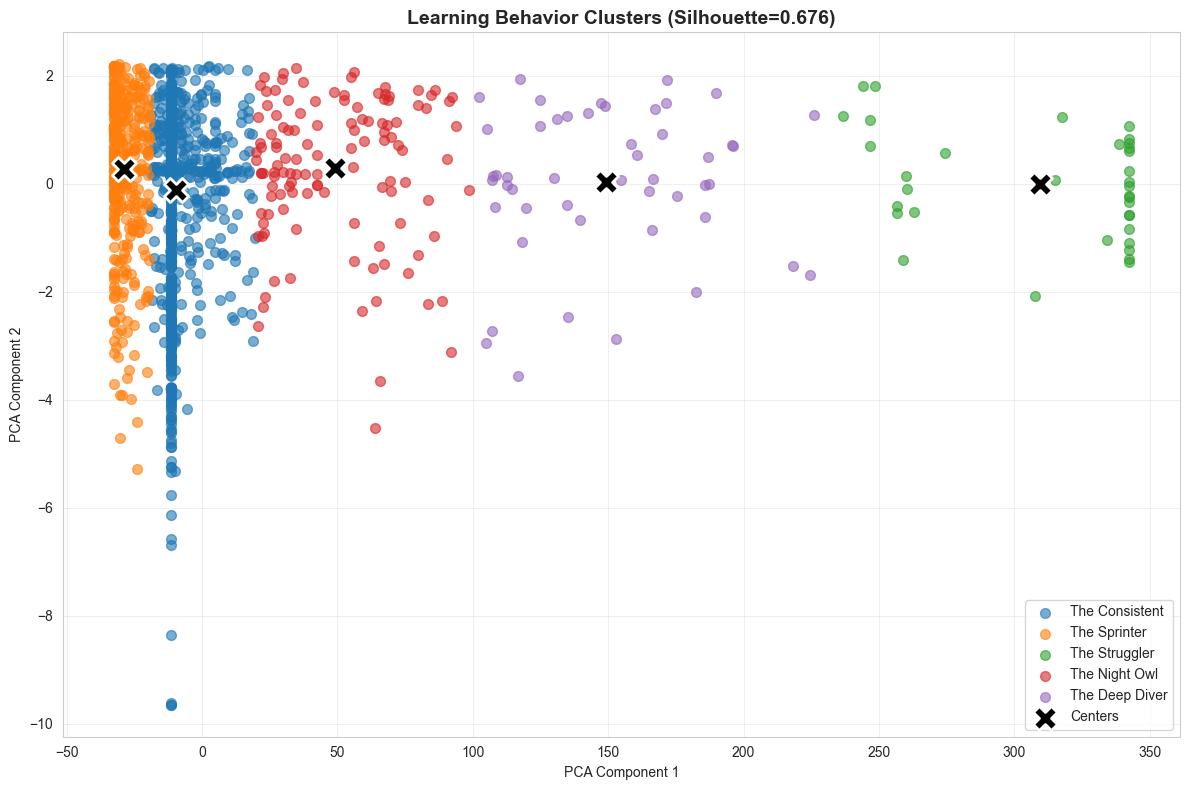


✅ Visualization Complete!


: 

In [ ]:
# PCA for visualization (2D)
pca_viz = PCA(n_components=2, random_state=42)
X_pca = pca_viz.fit_transform(X_final_scaled)

df_clean['pca_1'] = X_pca[:, 0]
df_clean['pca_2'] = X_pca[:, 1]

# Plot clusters
plt.figure(figsize=(12, 8))
for persona in df_clean['persona'].unique():
    mask = df_clean['persona'] == persona
    plt.scatter(df_clean.loc[mask, 'pca_1'], 
                df_clean.loc[mask, 'pca_2'], 
                label=persona, alpha=0.6, s=50)

# Plot centers
centers_pca = pca_viz.transform(centers_scaled)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            c='black', marker='X', s=300, edgecolors='white', linewidths=2, label='Centers')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'Learning Behavior Clusters (Silhouette={final_silhouette:.3f})', fontsize=14, weight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Visualization Complete!")